# Entraîner un modèle Transformer pour la traduction - CORRECTION

**Objectif pédagogique :** Apprendre à construire et entraîner un modèle de traduction automatique Anglais → Français

## Installation et imports

**Objectif :** Installer les bibliothèques modernes pour le deep learning et le NLP

In [1]:
# Installation des packages modernes (exécuter une seule fois)
!pip install transformers datasets torch torchvision torchaudio
!pip install pandas matplotlib tqdm scikit-learn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Bibliothèques pour NLP moderne
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import math
import os
from typing import List
from timeit import default_timer as timer

## Configuration et détection matériel

**Concept important :** Il est crucial de détecter si un GPU est disponible pour accélérer l'entraînement !

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device utilisé: {DEVICE}")

# Configuration de la reproductibilité
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    # Configuration pour performances reproductibles sur GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

🖥️  Device utilisé: cuda


## Hyperparamètres

In [22]:
EMB_SIZE = 256  # Dimension des embeddings (doit être divisible par NHEAD)
NHEAD = 8       # Nombre de têtes d'attention (8 divise 256)
FFN_HID_DIM = 512  # Dimension de la couche feed-forward

# Adaptation de la batch size selon les capacités du device
BATCH_SIZE = 64 if DEVICE.type == 'cuda' else 32  # GPU peut traiter plus de données

NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 15  # Nombre d'époques d'entraînement
LEARNING_RATE = 0.0001  # Taux d'apprentissage conservateur

print(f"📊 Batch size: {BATCH_SIZE}")
print(f"🧠 Embedding size: {EMB_SIZE}")
print(f"👁️  Attention heads: {NHEAD}")
print(f"🔥 Epochs: {NUM_EPOCHS}")

📊 Batch size: 64
🧠 Embedding size: 256
👁️  Attention heads: 8
🔥 Epochs: 15


## Chargement des données

**Dataset :** Nous utilisons un dataset de phrases parallèles Anglais-Français

In [23]:
# Chargement du dataset (fourni)
try:
    import kagglehub
    path = kagglehub.dataset_download("devicharith/language-translation-englishfrench")
    csv_path = os.path.join(path, 'eng_-french.csv')
except:
    # Alternative: mettre votre chemin local
    csv_path = 'eng_-french.csv'

# CORRECTION: Chargement avec pandas et sélection des colonnes nécessaires
df = pd.read_csv(
    csv_path,
    usecols=['English words/sentences', 'French words/sentences']
)
df = df.dropna()  # Supprimer les valeurs manquantes

print(f"📊 Dataset size: {len(df)} exemples")
# Affichage des premières lignes pour vérification
print(df.head())

Using Colab cache for faster access to the 'language-translation-englishfrench' dataset.
📊 Dataset size: 175621 exemples
  English words/sentences French words/sentences
0                     Hi.                 Salut!
1                    Run!                Cours !
2                    Run!               Courez !
3                    Who?                  Qui ?
4                    Wow!             Ça alors !


## Tokenisation moderne

**Concept :** Les tokenizers pré-entraînés sont plus efficaces que construire le sien from scratch

In [24]:
# CORRECTION: Initialisation des tokenizers modernes

from transformers import AutoTokenizer

# Tokenizers pré-entraînés optimisés
tokenizer_en = AutoTokenizer.from_pretrained("bert-base-uncased")  # Anglais
tokenizer_fr = AutoTokenizer.from_pretrained("camembert-base")     # Français

# Test des tokenizers
test_en = "Hello I love machine learning"
test_fr = "Bonjour j'adore l'apprentissage automatique"

print(f"🔤 Tokenization EN: {tokenizer_en.tokenize(test_en)}")
print(f"🔤 Tokenization FR: {tokenizer_fr.tokenize(test_fr)}")

print("✅ Tokenizers initialisés !")

# Note: Ces tokenizers sont bien plus sophistiqués que les tokenizers basiques
# Ils gèrent les sous-mots (subwords) et ont été entraînés sur de gros corpus

🔤 Tokenization EN: ['hello', 'i', 'love', 'machine', 'learning']
🔤 Tokenization FR: ['▁Bonjour', '▁j', "'", 'adore', '▁l', "'", 'apprentissage', '▁automatique']
✅ Tokenizers initialisés !


## Construction du vocabulaire

In [25]:
# Tokens spéciaux (fourni)
PAD_IDX = 0  # Padding
BOS_IDX = 1  # Beginning of Sentence
EOS_IDX = 2  # End of Sentence
UNK_IDX = 3  # Unknown word

def build_vocab(sentences, tokenizer, max_vocab=10000):
    """Construction du vocabulaire à partir des phrases"""
    word_count = {}

    # CORRECTION: Parcours et comptage des mots
    for sentence in sentences:
        tokens = tokenizer.tokenize(str(sentence))
        for token in tokens:
            # Incrémentation du compteur pour chaque token
            word_count[token] = word_count.get(token, 0) + 1

    # CORRECTION: Tri par fréquence décroissante
    sorted_words = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

    # Création du vocabulaire avec tokens spéciaux
    vocab = {"<pad>": PAD_IDX, "<bos>": BOS_IDX, "<eos>": EOS_IDX, "<unk>": UNK_IDX}

    # CORRECTION: Ajout des mots les plus fréquents
    for word, _ in sorted_words[:max_vocab-4]:  # -4 pour les tokens spéciaux
        vocab[word] = len(vocab)  # Assigne un index unique à chaque mot

    return vocab

# Construction des vocabulaires
vocab_en = build_vocab(df['English words/sentences'], tokenizer_en)
vocab_fr = build_vocab(df['French words/sentences'], tokenizer_fr)

print(f"📖 Vocabulaire EN: {len(vocab_en)} mots")
print(f"📖 Vocabulaire FR: {len(vocab_fr)} mots")

📖 Vocabulaire EN: 10000 mots
📖 Vocabulaire FR: 10000 mots


## Dataset personnalisé

**Architecture :** PyTorch utilise des classes Dataset pour organiser les données

In [26]:
def text_to_indices(text, tokenizer, vocab, max_len=50):
    """Convertit un texte en indices avec BOS et EOS"""
    tokens = tokenizer.tokenize(str(text))[:max_len-2]  # Place pour BOS/EOS

    # CORRECTION: Conversion des tokens en indices
    # Utilisation de vocab.get() pour gérer les mots inconnus
    indices = [BOS_IDX] + [vocab.get(token, UNK_IDX) for token in tokens] + [EOS_IDX]

    return torch.tensor(indices, dtype=torch.long)

class TranslationDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        # CORRECTION: Retourner la taille du dataset
        return len(self.df)

    def __getitem__(self, idx):
        # CORRECTION: Extraction des textes anglais et français
        en_text = self.df.iloc[idx]['English words/sentences']
        fr_text = self.df.iloc[idx]['French words/sentences']

        # Conversion en indices
        en_indices = text_to_indices(en_text, tokenizer_en, vocab_en)
        fr_indices = text_to_indices(fr_text, tokenizer_fr, vocab_fr)

        return en_indices, fr_indices

print("✅ Classes Dataset définies !")

✅ Classes Dataset définies !


## DataLoaders

**Concept :** Le padding permet de traiter des phrases de longueurs différentes dans le même batch

In [27]:
def collate_batch(batch):
    """Fonction pour créer des batchs avec padding"""
    src_batch, tgt_batch = zip(*batch)

    # CORRECTION: Utilisation de pad_sequence pour uniformiser les longueurs
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)

    return src_batch, tgt_batch

# CORRECTION: Division train/test avec scikit-learn
train_df, test_df = train_test_split(
    df,
    test_size=0.1,  # 10% pour le test
    random_state=SEED  # Reproductibilité
)

# CORRECTION: Création des datasets
train_dataset = TranslationDataset(train_df)
test_dataset = TranslationDataset(test_df)

# CORRECTION: Création des DataLoaders avec tous les paramètres
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Mélange pour l'entraînement
    collate_fn=collate_batch,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Pas de mélange pour l'évaluation
    collate_fn=collate_batch,
    num_workers=0
)

print(f"🔄 Training batches: {len(train_loader)}")
print(f"🔄 Test batches: {len(test_loader)}")

🔄 Training batches: 2470
🔄 Test batches: 275


## Architecture du modèle Transformer

**Architecture :** Le Transformer utilise l'attention pour "encoder" les relations entre mots

In [28]:
class PositionalEncoding(nn.Module):
    """Encodage positionnel pour que le modèle comprenne l'ordre des mots"""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # CORRECTION: Création du tensor d'encodage positionnel
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Formule mathématique pour l'encodage positionnel (from paper)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # Positions paires: sin
        pe[:, 1::2] = torch.cos(position * div_term)  # Positions impaires: cos
        pe = pe.unsqueeze(0)  # Ajout dimension batch

        self.register_buffer('pe', pe)  # Buffer = tensor non-entraînable

    def forward(self, x):
        # CORRECTION: Addition de l'encodage positionnel aux embeddings
        x = x + self.pe[:, :x.size(1)]  # Prendre seulement la longueur nécessaire
        return self.dropout(x)

print("✅ PositionalEncoding défini !")

✅ PositionalEncoding défini !


In [29]:
class TransformerTranslator(nn.Module):
    """Modèle Transformer complet pour la traduction"""
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, nhead=8,
                 num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()

        self.d_model = d_model

        # CORRECTION: Couches d'embedding pour les vocabulaires source et target
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # CORRECTION: Encodage positionnel
        self.pos_encoding = PositionalEncoding(d_model, dropout)

        # CORRECTION: Architecture Transformer avec tous les paramètres
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # Important: batch en première dimension
        )

        # CORRECTION: Couche de projection finale vers le vocabulaire target
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)

        # Initialisation des poids (bonne pratique)
        self.init_weights()

    def init_weights(self):
        """Initialisation Xavier/Glorot pour meilleure convergence
        PyTorch utilise par défaut : Normal(0, 1) pour les embeddings
        PyTorch utilise : Uniform(-1/sqrt(in_features), 1/sqrt(in_features)) pour les Linear
        Les embeddings avec Normal(0,1) peuvent être trop grands Uniform(-0.1, 0.1) plus stable pour l'attention"""
        initrange = 0.1
        self.src_embedding.weight.data.uniform_(-initrange, initrange)
        self.tgt_embedding.weight.data.uniform_(-initrange, initrange)
        self.output_projection.bias.data.zero_()
        self.output_projection.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None,
                src_key_padding_mask=None, tgt_key_padding_mask=None):

        # CORRECTION: Embeddings avec scaling (important pour la stabilité)
        src_emb = self.pos_encoding(self.src_embedding(src) * math.sqrt(self.d_model))
        tgt_emb = self.pos_encoding(self.tgt_embedding(tgt) * math.sqrt(self.d_model))

        # CORRECTION: Passage dans le Transformer
        output = self.transformer(
            src_emb, tgt_emb,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        # CORRECTION: Projection finale vers le vocabulaire
        return self.output_projection(output)

print("✅ Modèle Transformer défini !")

✅ Modèle Transformer défini !


## Création des masques

**Concept crucial :** Les masques empêchent le modèle de "tricher" en regardant les mots futurs

In [30]:
def create_masks(src, tgt):
    """Crée les masques nécessaires pour l'attention"""
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    # CORRECTION: Masque causal triangulaire supérieur
    # Empêche le décodeur de voir les mots futurs
    tgt_mask = torch.triu(
        torch.ones(tgt_seq_len, tgt_seq_len, device=src.device),
        diagonal=1  # Diagonale supérieure = positions futures
    ).bool()  # Conversion en bool pour éviter warning

    # CORRECTION: Masques de padding pour ignorer les tokens PAD (type bool)
    src_padding_mask = (src == PAD_IDX)  # True où il y a du padding
    tgt_padding_mask = (tgt == PAD_IDX)  # True où il y a du padding

    # Convertir tgt_mask en masque avec -inf pour compatibilité
    tgt_mask = tgt_mask.float().masked_fill(tgt_mask == 1, float('-inf')).masked_fill(tgt_mask == 0, 0.0)

    return None, tgt_mask, src_padding_mask, tgt_padding_mask

print("✅ Fonction de masques définie !")

✅ Fonction de masques définie !


## Initialisation du modèle

In [31]:
# CORRECTION: Initialisation complète du modèle
model = TransformerTranslator(
    src_vocab_size=len(vocab_en),
    tgt_vocab_size=len(vocab_fr),
    d_model=EMB_SIZE,
    nhead=NHEAD,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=FFN_HID_DIM
).to(DEVICE)  # IMPORTANT: Déplacer sur le bon device!

# CORRECTION: Comptage précis des paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🧮 Paramètres totaux: {total_params:,}")
print(f"🧮 Paramètres entraînables: {trainable_params:,}")

# Estimation mémoire approximative
memory_mb = (total_params * 4) / (1024**2)  # 4 bytes par paramètre float32
print(f"💾 Mémoire approximative: {memory_mb:.1f} MB")

# Breakdown détaillé des paramètres
print(f"\n📊 Détail des composants:")
print(f"  📖 Embeddings EN: {len(vocab_en) * EMB_SIZE:,} params")
print(f"  📖 Embeddings FR: {len(vocab_fr) * EMB_SIZE:,} params")
print(f"  🔄 Transformer: {total_params - len(vocab_en)*EMB_SIZE - len(vocab_fr)*EMB_SIZE - len(vocab_fr)*EMB_SIZE:,} params")
print(f"  📤 Output projection: {EMB_SIZE * len(vocab_fr):,} params")

🧮 Paramètres totaux: 11,644,688
🧮 Paramètres entraînables: 11,644,688
💾 Mémoire approximative: 44.4 MB

📊 Détail des composants:
  📖 Embeddings EN: 2,560,000 params
  📖 Embeddings FR: 2,560,000 params
  🔄 Transformer: 3,964,688 params
  📤 Output projection: 2,560,000 params


## Configuration de l'entraînement

**Optimisation :** Le gradient clipping évite les explosions de gradient

In [32]:
# CORRECTION: Configuration complète de l'entraînement

# Fonction de coût qui ignore les tokens de padding
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Optimiseur AdamW (version améliorée d'Adam)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.98),  # Coefficients recommandés pour Transformers
    eps=1e-9,
    weight_decay=0.01
)

# Scheduler pour réduire le learning rate progressivement
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,  # Réduire tous les 5 époques
    gamma=0.7     # Facteur de réduction
)

## Fonctions d'entraînement

In [33]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entraîne le modèle pour une époque"""
    # CORRECTION: Mode entraînement (active dropout, batch norm)
    model.train()

    total_loss = 0
    num_batches = len(train_loader)

    for src, tgt in tqdm(train_loader, desc="Training"):
        # CORRECTION: Déplacement des données sur le device
        src, tgt = src.to(device), tgt.to(device)

        # CORRECTION: Préparation teacher forcing
        # Input = toute la séquence sauf le dernier token
        # Output = toute la séquence sauf le premier token (BOS)
        tgt_input = tgt[:, :-1]  # [BOS, w1, w2, w3]
        tgt_output = tgt[:, 1:]  # [w1, w2, w3, EOS]

        # CORRECTION: Création des masques
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_masks(src, tgt_input)

        # CORRECTION: Forward pass
        logits = model(
            src, tgt_input,
            src_mask, tgt_mask,
            src_padding_mask, tgt_padding_mask
        )

        # CORRECTION: Calcul de la loss avec reshape approprié
        loss = criterion(
            logits.reshape(-1, logits.shape[-1]),  # (batch*seq, vocab)
            tgt_output.reshape(-1)                 # (batch*seq,)
        )

        # CORRECTION: Backward pass avec gradient clipping
        optimizer.zero_grad()  # Reset gradients
        loss.backward()        # Calcul gradients
        # Gradient clipping pour éviter l'explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()       # Mise à jour paramètres

        total_loss += loss.item()

    return total_loss / num_batches

print("✅ Fonction train_epoch définie !")

✅ Fonction train_epoch définie !


In [34]:
def evaluate(model, test_loader, criterion, device):
    """Évalue le modèle sur les données de test"""
    # CORRECTION: Mode évaluation (désactive dropout, batch norm)
    model.eval()

    total_loss = 0
    num_batches = len(test_loader)

    # CORRECTION: Pas de calcul de gradients pour économiser mémoire
    with torch.no_grad():
        for src, tgt in tqdm(test_loader, desc="Evaluating"):
            # Même logique que l'entraînement mais sans backward pass
            src, tgt = src.to(device), tgt.to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_masks(src, tgt_input)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))

            total_loss += loss.item()

    return total_loss / num_batches

print("✅ Fonction evaluate définie !")

✅ Fonction evaluate définie !


## Boucle d'entraînement principale

In [40]:
# CORRECTION: Boucle d'entraînement complète avec monitoring

# Listes pour stocker l'historique
train_losses = []
val_losses = []
best_val_loss = float('inf')

print("🚀 Début de l'entraînement !")
print("=" * 60)

# CORRECTION: Boucle principale d'entraînement
for epoch in range(NUM_EPOCHS):
    start_time = timer()

    # CORRECTION: Phase d'entraînement
    train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

    # CORRECTION: Phase de validation
    val_loss = evaluate(model, test_loader, criterion, DEVICE)

    # CORRECTION: Mise à jour du learning rate
    scheduler.step()

    end_time = timer()

    # Sauvegarde de l'historique
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Affichage détaillé des métriques
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"  📊 Train Loss: {train_loss:.4f}")
    print(f"  📊 Val Loss: {val_loss:.4f}")
    print(f"  ⏱️  Time: {end_time - start_time:.2f}s")
    print(f"  🎚️  LR: {scheduler.get_last_lr()[0]:.6f}")

    # Détection d'amélioration
    improvement = ""
    if len(val_losses) > 1:
        diff = val_losses[-2] - val_losses[-1]
        if diff > 0:
            improvement = f" (↓ -{diff:.4f})"
        else:
            improvement = f" (↑ +{abs(diff):.4f})"

    print(f"  📈 Progression: {improvement}")

    # CORRECTION: Sauvegarde du meilleur modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_loss,
            'train_loss': train_loss,
            'vocab_en': vocab_en,
            'vocab_fr': vocab_fr,
            'hyperparams': {
                'EMB_SIZE': EMB_SIZE,
                'NHEAD': NHEAD,
                'NUM_ENCODER_LAYERS': NUM_ENCODER_LAYERS,
                'NUM_DECODER_LAYERS': NUM_DECODER_LAYERS,
                'FFN_HID_DIM': FFN_HID_DIM
            }
        }, 'best_model_students_correction.pt')
        print(f"  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: {val_loss:.4f})")

    # Early stopping simple
    if len(val_losses) > 3:
        if all(val_losses[i] <= val_losses[i+1] for i in range(-4, -1)):
            print(f"  ⚠️  Attention: val_loss stagne depuis 3 époques")

    print("-" * 50)

print("\n🎉 Entraînement terminé !")
print(f"🏆 Meilleure validation loss: {best_val_loss:.4f}")

🚀 Début de l'entraînement !


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 1/15:
  📊 Train Loss: 1.3981
  📊 Val Loss: 1.4161
  ⏱️  Time: 130.50s
  🎚️  LR: 0.000070
  📈 Progression: 
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.4161)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

     if w.is_alive(): 
               ^ ^^^^^^^^^^^^^^^^^^^^^^^


Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       Exception ignored in: if w.is_alive():  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
  
 Traceback (most recent call last):
^   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", li

Epoch 2/15:
  📊 Train Loss: 1.3243
  📊 Val Loss: 1.3663
  ⏱️  Time: 136.94s
  🎚️  LR: 0.000070
  📈 Progression:  (↓ -0.0498)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.3663)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Epoch 3/15:
  📊 Train Loss: 1.2641
  📊 Val Loss: 1.3305
  ⏱️  Time: 131.38s
  🎚️  LR: 0.000070
  📈 Progression:  (↓ -0.0358)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.3305)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
      Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    if w.is_alive():^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process'
            ^^^^^ ^  ^ ^^ ^^^^^
^  File "/

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>    
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():    
 self._shutdown_workers()  
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():
     ^ ^ ^  ^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  
  File "/usr/lib/pyth

Epoch 4/15:
  📊 Train Loss: 1.2130
  📊 Val Loss: 1.2883
  ⏱️  Time: 132.53s
  🎚️  LR: 0.000070
  📈 Progression:  (↓ -0.0422)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.2883)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>^^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    self._shutdown_workers()

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive(): 
          ^    ^^  ^^ ^^^^^^^^^^^^^^
^  Fi

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660> 
 Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^^
^  ^ ^  ^ ^ 
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^^ ^ ^ ^ ^^ ^  
  File "/usr/lib

Epoch 5/15:
  📊 Train Loss: 1.1675
  📊 Val Loss: 1.2661
  ⏱️  Time: 136.89s
  🎚️  LR: 0.000049
  📈 Progression:  (↓ -0.0221)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.2661)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^
if w.is_alive():  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

       assert self._parent_pid == os.getpid(), 'can only test a child process'  
   ^ ^ ^^^^ ^ ^ ^^^ ^
   File "/usr/li

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    if w.is_alive():    Exception ignored in: Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660> 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


     Traceback (most recent call last):
if w.is_alive():  

Epoch 6/15:
  📊 Train Loss: 1.1165
  📊 Val Loss: 1.2403
  ⏱️  Time: 147.10s
  🎚️  LR: 0.000049
  📈 Progression:  (↓ -0.0258)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.2403)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Epoch 7/15:
  📊 Train Loss: 1.0895
  📊 Val Loss: 1.2285
  ⏱️  Time: 133.85s
  🎚️  LR: 0.000049
  📈 Progression:  (↓ -0.0119)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.2285)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>

Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
           ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 8/15:
  📊 Train Loss: 1.0640
  📊 Val Loss: 1.2208
  ⏱️  Time: 133.10s
  🎚️  LR: 0.000049
  📈 Progression:  (↓ -0.0076)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.2208)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     if w.is_alive():^^
^ ^  ^^ ^ ^  ^^^^^^^^^^^^^^^^^

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 9/15:
  📊 Train Loss: 1.0423
  📊 Val Loss: 1.2116
  ⏱️  Time: 136.02s
  🎚️  LR: 0.000049
  📈 Progression:  (↓ -0.0093)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.2116)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()    if w.is_alive():

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
        ^  ^ ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
  
  File "/usr/lib/pyth

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660> 
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    if w.is_alive():^
^ ^^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
^^ ^  ^^ ^ ^ ^ ^ ^^ ^
  File "/usr/l

Epoch 10/15:
  📊 Train Loss: 1.0207
  📊 Val Loss: 1.2001
  ⏱️  Time: 143.21s
  🎚️  LR: 0.000034
  📈 Progression:  (↓ -0.0115)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.2001)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Epoch 11/15:
  📊 Train Loss: 0.9930
  📊 Val Loss: 1.1980
  ⏱️  Time: 132.32s
  🎚️  LR: 0.000034
  📈 Progression:  (↓ -0.0020)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.1980)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>  ^^^^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^^^    ^self._shutdown_workers()^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():   
              ^ ^^^^^^^^^^^^^^^^^^^^^^^^

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():  
    ^ ^ ^ ^  ^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^

   File "/usr/lib/pytho

Epoch 12/15:
  📊 Train Loss: 0.9785
  📊 Val Loss: 1.1789
  ⏱️  Time: 134.15s
  🎚️  LR: 0.000034
  📈 Progression:  (↓ -0.0191)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.1789)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>   
 Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()
 ^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^^if w.is_alive():^
^   ^ ^ ^ ^^ ^^^^^^^^^^^^^

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():    
 if w.is_alive():
          ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self.

Epoch 13/15:
  📊 Train Loss: 0.9656
  📊 Val Loss: 1.1755
  ⏱️  Time: 140.48s
  🎚️  LR: 0.000034
  📈 Progression:  (↓ -0.0034)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.1755)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660> 
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^^if w.is_alive():

   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
      ^ ^ ^ ^ ^ ^ ^ ^ ^^^^^^^^
^  File 

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>

  Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        ^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():
^ ^ ^^ ^ ^ ^ Exception ignored in: 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ce2dc232660>    ^
assert self._par

Epoch 14/15:
  📊 Train Loss: 0.9533
  📊 Val Loss: 1.1676
  ⏱️  Time: 146.55s
  🎚️  LR: 0.000034
  📈 Progression:  (↓ -0.0079)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.1676)
--------------------------------------------------


Training:   0%|          | 0/2470 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/275 [00:00<?, ?it/s]

Epoch 15/15:
  📊 Train Loss: 0.9412
  📊 Val Loss: 1.1650
  ⏱️  Time: 135.76s
  🎚️  LR: 0.000024
  📈 Progression:  (↓ -0.0026)
  🎯 Nouveau meilleur modèle sauvegardé! (val_loss: 1.1650)
--------------------------------------------------

🎉 Entraînement terminé !
🏆 Meilleure validation loss: 1.1650


## Visualisation des résultats

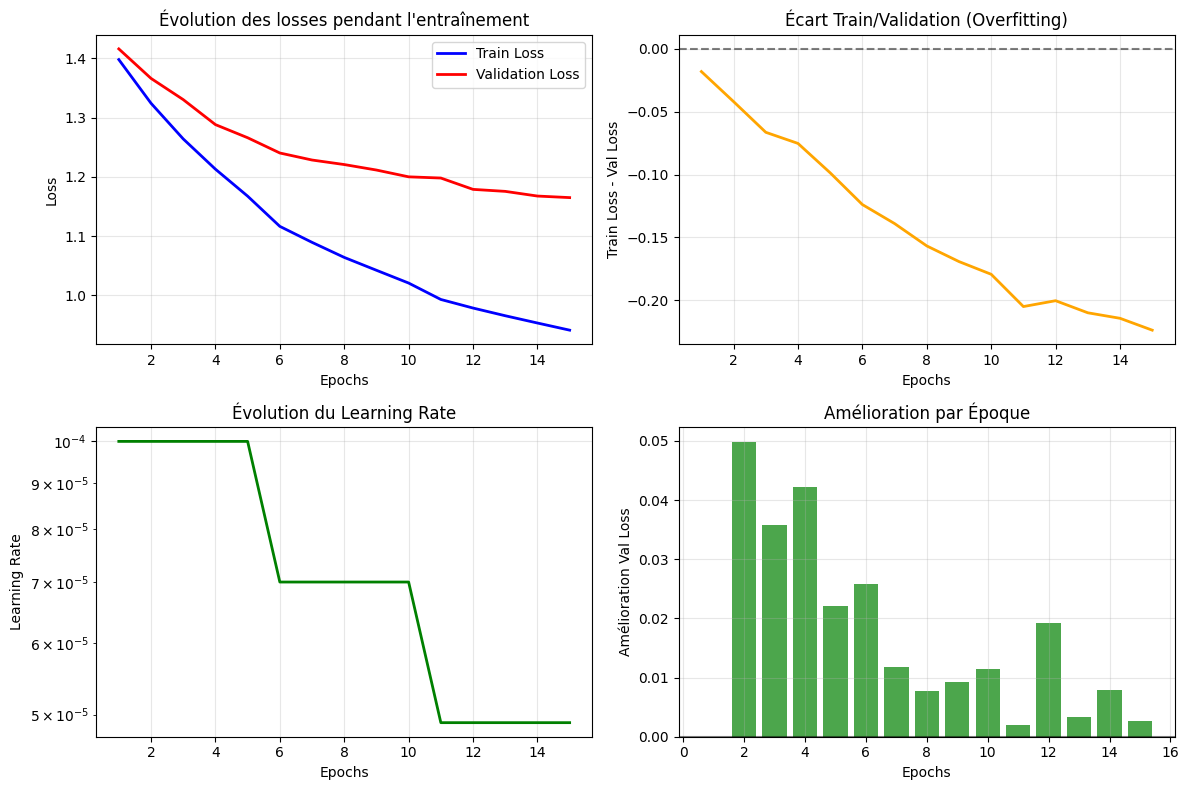

📈 Analyse automatique des résultats:
  🏆 Meilleure val loss: 1.1650
  📊 Loss finale train: 0.9412
  📊 Loss finale val: 1.1650
  📉 Réduction train loss: 32.7%
  📉 Réduction val loss: 17.7%
  ⚠️  UNDERFITTING possible (écart: -0.224)
  📊 Convergence en cours (std récente: 0.0117)


<Figure size 640x480 with 0 Axes>

In [41]:

plt.figure(figsize=(12, 8))

# Subplot 1: Courbes de loss
plt.subplot(2, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses,
         label='Train Loss', color='blue', linewidth=2)
plt.plot(range(1, len(val_losses) + 1), val_losses,
         label='Validation Loss', color='red', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Évolution des losses pendant l\'entraînement')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Différence train/val (détection overfitting)
plt.subplot(2, 2, 2)
diff_losses = [t - v for t, v in zip(train_losses, val_losses)]
plt.plot(range(1, len(diff_losses) + 1), diff_losses,
         color='orange', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Epochs')
plt.ylabel('Train Loss - Val Loss')
plt.title('Écart Train/Validation (Overfitting)')
plt.grid(True, alpha=0.3)

# Subplot 3: Learning rate évolution
plt.subplot(2, 2, 3)
lrs = [LEARNING_RATE * (scheduler.gamma ** (i // scheduler.step_size))
       for i in range(len(train_losses))]
plt.plot(range(1, len(lrs) + 1), lrs, color='green', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Évolution du Learning Rate')
plt.yscale('log')  # Échelle logarithmique pour mieux voir
plt.grid(True, alpha=0.3)

# Subplot 4: Amélioration par époque
plt.subplot(2, 2, 4)
val_improvements = [0] + [val_losses[i-1] - val_losses[i]
                          for i in range(1, len(val_losses))]
colors = ['green' if x > 0 else 'red' for x in val_improvements]
plt.bar(range(1, len(val_improvements) + 1), val_improvements, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Epochs')
plt.ylabel('Amélioration Val Loss')
plt.title('Amélioration par Époque')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sauvegarde du graphique
plt.savefig('training_analysis_correction.png', dpi=300, bbox_inches='tight')

# Analyse automatique des résultats
print("📈 Analyse automatique des résultats:")
print("=" * 50)
print(f"  🏆 Meilleure val loss: {best_val_loss:.4f}")
print(f"  📊 Loss finale train: {train_losses[-1]:.4f}")
print(f"  📊 Loss finale val: {val_losses[-1]:.4f}")
print(f"  📉 Réduction train loss: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")
print(f"  📉 Réduction val loss: {((val_losses[0] - val_losses[-1]) / val_losses[0] * 100):.1f}%")

# Détection automatique des problèmes
final_gap = train_losses[-1] - val_losses[-1]
if final_gap > 0.5:
    print(f"  ⚠️  OVERFITTING détecté (écart: {final_gap:.3f})")
elif final_gap < -0.2:
    print(f"  ⚠️  UNDERFITTING possible (écart: {final_gap:.3f})")
else:
    print(f"  ✅ Équilibre train/val correct (écart: {final_gap:.3f})")

# Convergence
if len(val_losses) > 5:
    recent_std = np.std(val_losses[-5:])
    if recent_std < 0.01:
        print(f"  ✅ Convergence stable (std récente: {recent_std:.4f})")
    else:
        print(f"  📊 Convergence en cours (std récente: {recent_std:.4f})")

## Test du modèle

**Le moment de vérité :** Votre modèle sait-il traduire ?

In [42]:
# CORRECTION: Chargement du meilleur modèle
checkpoint = torch.load('best_model_students_correction.pt', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Meilleur modèle chargé (époque {checkpoint['epoch']}, val_loss: {checkpoint['val_loss']:.4f})")

# Vocabulaire inversé pour la conversion
idx_to_word_fr = {idx: word for word, idx in vocab_fr.items()}

def translate_sentence(model, sentence, max_length=50, verbose=False):
    """Traduit une phrase anglaise en français avec décodage greedy"""
    model.eval()

    with torch.no_grad():
        # CORRECTION: Préprocessing de la phrase source
        src_indices = text_to_indices(sentence, tokenizer_en, vocab_en)
        src = src_indices.unsqueeze(0).to(DEVICE)

        if verbose:
            print(f"Source tokens: {[vocab_en_inv.get(idx.item(), '<unk>') for idx in src_indices]}")

        # CORRECTION: Initialisation avec BOS token
        tgt = torch.tensor([[BOS_IDX]], device=DEVICE)

        # Génération auto-régressive mot par mot
        for step in range(max_length):
            # CORRECTION: Création des masques pour l'état actuel
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_masks(src, tgt)

            # CORRECTION: Prédiction du prochain token
            logits = model(
                src, tgt,
                src_mask, tgt_mask,
                src_padding_mask, tgt_padding_mask
            )

            # CORRECTION: Sélection du token le plus probable (greedy)
            next_token = logits[0, -1].argmax().unsqueeze(0).unsqueeze(0)

            if verbose:
                probs = F.softmax(logits[0, -1], dim=0)
                top_tokens = probs.topk(3)
                print(f"Step {step}: Top tokens: {[(idx_to_word_fr.get(idx.item(), '<unk>'), prob.item()) for idx, prob in zip(top_tokens.indices, top_tokens.values)]}")

            # Arrêt si EOS généré
            if next_token.item() == EOS_IDX:
                break

            # CORRECTION: Ajout du nouveau token à la séquence
            tgt = torch.cat([tgt, next_token], dim=1)

        # CORRECTION: Conversion des indices vers les mots
        translation = []
        for idx in tgt[0][1:]:  # Ignorer BOS au début
            word = idx_to_word_fr.get(idx.item(), '<unk>')
            if word in ['<eos>', '<pad>']:
                break
            translation.append(word)

        # Post-processing basique pour améliorer la lisibilité
        result = ' '.join(translation)
        # Corrections de ponctuation basiques
        result = result.replace(' ,', ',').replace(' .', '.').replace(' !', '!').replace(' ?', '?').replace('_', '')

        return result

print("✅ Fonction de traduction définie !")

# Vocabulaire inversé pour debug
vocab_en_inv = {idx: word for word, idx in vocab_en.items()}

✅ Meilleur modèle chargé (époque 14, val_loss: 1.1650)
✅ Fonction de traduction définie !


In [43]:
# CORRECTION: Tests complets avec analyse de qualité

test_sentences = [
    "Hello, how are you?",
    "I love machine learning.",
    "The weather is beautiful today.",
    "Thank you very much.",
    "Good morning!",
    "What is your name?",
    "I am learning French.",
    "The book is on the table.",
    "Where are you going?",
    "This is a difficult problem."
]

# Traductions de référence pour comparaison
references = [
    "Bonjour, comment allez-vous ?",
    "J'adore l'apprentissage automatique.",
    "Le temps est beau aujourd'hui.",
    "Merci beaucoup.",
    "Bonjour !",
    "Comment vous appelez-vous ?",
    "J'apprends le français.",
    "Le livre est sur la table.",
    "Où allez-vous ?",
    "C'est un problème difficile."
]

print("🎯 Test de traduction avec évaluation:")
print("=" * 70)

total_score = 0
for i, sentence in enumerate(test_sentences):
    translation = translate_sentence(model, sentence)

    print(f"\n📝 Test {i+1}:")
    print(f"🇬🇧 EN: {sentence}")
    print(f"🤖 AI: {translation}")
    print(f"📚 REF: {references[i]}")

    # Évaluation qualitative simple
    prediction_words = set(translation.lower().split())
    reference_words = set(references[i].lower().split())

    if prediction_words and reference_words:
        overlap = len(prediction_words & reference_words)
        union = len(prediction_words | reference_words)
        jaccard = overlap / union if union > 0 else 0
        total_score += jaccard

        if jaccard > 0.6:
            quality = "🟢 Excellent"
        elif jaccard > 0.4:
            quality = "🟡 Correct"
        elif jaccard > 0.2:
            quality = "🟠 Partiel"
        else:
            quality = "🔴 Faible"

        print(f"📊 Similarité: {jaccard:.2f} {quality}")

    print("-" * 40)

average_score = total_score / len(test_sentences)
print(f"\n🏆 Score moyen: {average_score:.3f}")

if average_score > 0.5:
    print("🎉 Performance globale: BONNE !")
elif average_score > 0.3:
    print("👍 Performance globale: Correcte")
else:
    print("📚 Performance globale: À améliorer")

🎯 Test de traduction avec évaluation:

📝 Test 1:
🇬🇧 EN: Hello, how are you?
🤖 AI: ▁Salut, ▁comment ▁tu ▁es ▁?
📚 REF: Bonjour, comment allez-vous ?
📊 Similarité: 0.00 🔴 Faible
----------------------------------------

📝 Test 2:
🇬🇧 EN: I love machine learning.
🤖 AI: ▁J ' adore ▁la ▁machine ▁à ▁apprendre.
📚 REF: J'adore l'apprentissage automatique.
📊 Similarité: 0.00 🔴 Faible
----------------------------------------

📝 Test 3:
🇬🇧 EN: The weather is beautiful today.
🤖 AI: ▁Le ▁temps ▁est ▁beau ▁aujourd ' hui.
📚 REF: Le temps est beau aujourd'hui.
📊 Similarité: 0.00 🔴 Faible
----------------------------------------

📝 Test 4:
🇬🇧 EN: Thank you very much.
🤖 AI: ▁Merci ▁beaucoup.
📚 REF: Merci beaucoup.
📊 Similarité: 0.00 🔴 Faible
----------------------------------------

📝 Test 5:
🇬🇧 EN: Good morning!
🤖 AI: ▁bonne ▁matin ▁!
📚 REF: Bonjour !
📊 Similarité: 0.00 🔴 Faible
----------------------------------------

📝 Test 6:
🇬🇧 EN: What is your name?
🤖 AI: ▁Quel ▁est ▁ton ▁nom ▁?
📚 REF: Comment vous

In [44]:
# Test interactif

print("✨ Test interactif - Ajoutez vos propres phrases:")
print("=" * 50)

# Vos phrases personnalisées que vous pouvez modifier
custom_sentences = [
    "The cat is sleeping on the sofa.",
    "I want to travel to Paris.",
    "Can you help me please?",
    "The students are working hard.",
    "Technology is changing the world."
]

for i, sentence in enumerate(custom_sentences):
    print(f"\n🧪 Test personnalisé {i+1}:")
    translation = translate_sentence(model, sentence)
    print(f"🇬🇧 EN: {sentence}")
    print(f"🇫🇷 FR: {translation}")

    # Analyse détaillée pour 1 exemple
    if i == 0:
        print("\n🔍 Analyse détaillée:")
        detailed_translation = translate_sentence(model, sentence, verbose=True)

✨ Test interactif - Ajoutez vos propres phrases:

🧪 Test personnalisé 1:
🇬🇧 EN: The cat is sleeping on the sofa.
🇫🇷 FR: ▁Le ▁chat ▁est ▁en ▁train ▁de ▁dormir ▁sur ▁le ▁canapé.

🔍 Analyse détaillée:
Source tokens: ['<bos>', 'the', 'cat', 'is', 'sleeping', 'on', 'the', 'sofa', '.', '<eos>']
Step 0: Top tokens: [('▁Le', 0.9814701676368713), ('▁La', 0.006666016764938831), ('▁Les', 0.003778642974793911)]
Step 1: Top tokens: [('▁chat', 0.9987282156944275), ('▁chatte', 0.0006238045752979815), ('▁chats', 8.200144657166675e-05)]
Step 2: Top tokens: [('▁est', 0.7650680541992188), ('▁dort', 0.19139693677425385), ('▁se', 0.005603547673672438)]
Step 3: Top tokens: [('▁en', 0.9230204224586487), ('▁dormir', 0.01475959550589323), ('▁de', 0.0132913151755929)]
Step 4: Top tokens: [('▁train', 0.9973196387290955), ('▁dort', 0.0003902761382050812), ('▁dormir', 0.00012928817886859179)]
Step 5: Top tokens: [('▁de', 0.9831043481826782), ('▁d', 0.015799630433321), ('▁qui', 0.00018058839486911893)]
Step 6: Top 